## Imports and Files

In [1381]:
# Classic Imports 
import pandas as pd
import numpy as np

import math
import time

# Accessing File Imports 
from pathlib import Path

# Plotting Imports 
from matplotlib import pyplot as plt

# Library FFT Imports 
from scipy.fft import fft, fftfreq

# Custom Imports
from wave_generator import create_wave

# All Relevant Variables 
csv_sampling_frequency = 250000
csv_num_data_points = 16384

is_data_from_sampleData1 = False

### Importing from sampleData1

In [1382]:
if (is_data_from_sampleData1 == True):

    # CSV Being Analyzed 
    dataFile = "./sampleData1/1.csv"

    def load_hydrophone_data():
        return pd.read_csv(Path(dataFile), header = None)

    hydrophoneData = load_hydrophone_data()

    def addTime(x): 
        return x / csv_sampling_frequency

    hydrophoneData.columns = ['hydrophone1', 'hydrophone2', 'hydrophone3', 'hydrophone4', 'time'] 
    hydrophoneData["time"] = hydrophoneData["time"].apply(addTime)

    sample = np.array(hydrophoneData["hydrophone1"])
    sampling_frequency = 250000

### Importing from sampleData2

In [1383]:
if (is_data_from_sampleData1 == False):

    # CSV Being Analyzed 
    dataFile = "./sampleData2/hydro2_3.5mA_pool_end_halfway_down.csv"

    def load_hydrophone_data():
        return pd.read_csv(Path(dataFile), skiprows = 9)
    
    sample = load_hydrophone_data()

    sample = np.array(sample["Channel 1 (V)"])
    sampling_frequency = 160000

## Data Visualizer 

In [1384]:
sample                                  # Gives first couple of lines of the csv

array([4.40775681, 4.4074254 , 4.41107095, ..., 4.41504792, 4.40444267,
       4.39980288])

## Temporary Manual Bandpass Filter 

In [1385]:
print("The original sample is ")
print(sample)
print("\n")

shift = float(np.mean(sample))

print("This is the shift by which all the values are shifted which is " + str(shift))
print("\n")

sample = sample - shift

print("The shifted and modified sample is + ")
print(sample)

The original sample is 
[4.40775681 4.4074254  4.41107095 ... 4.41504792 4.40444267 4.39980288]


This is the shift by which all the values are shifted which is 4.408553385065849


The shifted and modified sample is + 
[-0.00079657 -0.00112799  0.00251756 ...  0.00649453 -0.00411071
 -0.00875051]


In [1386]:
sample = sample * 100

<AxesSubplot: >

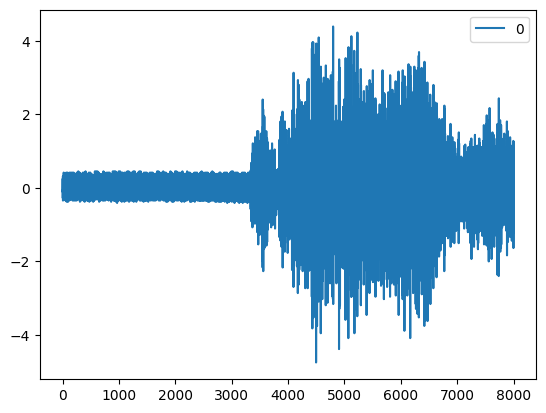

In [1387]:
sample1 = sample[0:8000]
sample1 = pd.DataFrame(sample1)

sample1.plot()

## Fourier Transform

In [1388]:
sampling_frequency                          # Sampling frequency of the hydrophone
N = 200                                     # The size of the shifting window in terms of the number of samples in the window 
startingIndex = 4000                        # This is the index of the first sample to be analyzed in the csv file data which is passed to the fourier analysis
endingIndex = 4200                          # This is the index of the last sample to be analyzed in the csv file data which is passed to the fourier analysis
sample                                      # The data that is to be input into the fourier analysis 

testsample = np.array(sample[startingIndex: endingIndex])

print("The sampling frequency is " + str(sampling_frequency))
print("The sample size is " + str(N))

The sampling frequency is 160000
The sample size is 200


Using the scipy library, 200 were analyzed in 0.00014495849609375 seconds.


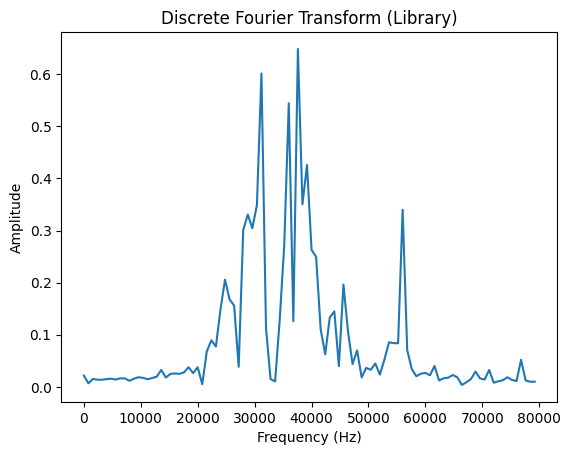

In [1389]:
# DISCRETE FOURIER ANALYSIS USING SCIPY LIBRARY
# ----------------------------------------------

# For measuring execution time. 
start = time.time()

# Number of samples in normalized_tone
yf = fft(testsample)
xf = fftfreq(N, 1 / sampling_frequency)[:(N // 2)]

end = time.time()
print("Using the scipy library, " + str(N) + " were analyzed in " + str(end - start) + " seconds.")

plt.plot(xf, 2 / N * np.abs(yf[0 : N//2]))        # Ignore this error 
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Discrete Fourier Transform (Library)")
plt.show()

## Sliding Fourier Transform for Edge Detection

In [1390]:
sampling_frequency                          # Sampling frequency of the hydrophone
N = 128                                     # The size of the shifting window in terms of the number of samples in the window 
startingIndex = 0000                        # This is the index of the first sample to be analyzed in the csv file data which is passed to the fourier analysis
endingIndex = 8000                          # This is the index of the last sample to be analyzed in the csv file data which is passed to the fourier analysis
sample                                      # The data that is to be input into the fourier analysis 

print("The sampling frequency is " + str(sampling_frequency))
print("The sample size is " + str(N))
print("The bucket size from the FFT is " + str(sampling_frequency / N))
print("The higheset frequency captured from the FFT is " + str(sampling_frequency / 2))

The sampling frequency is 160000
The sample size is 128
The bucket size from the FFT is 1250.0
The higheset frequency captured from the FFT is 80000.0


In [1391]:
chosenBucketSize = 5000
frequencyToWatch = 35000

sampleNumberArray = []
amplitudeArray = []

for i in range(startingIndex, (endingIndex - N + 1)):

    slidingTestSample = np.array(sample[i: i + N])

    yf = fft(slidingTestSample)
    xf = fftfreq(N, 1 / sampling_frequency)[:(N // 2)]

    frequencies = pd.DataFrame(xf, columns = ["Frequency"])
    amplitudes = pd.DataFrame((2 / N * np.abs(yf[0 : N//2])), columns = ["Amplitude"])

    values = pd.concat([frequencies, amplitudes], axis = 1)

    temp = chosenBucketSize / (sampling_frequency / N)
    index = 0
    newValues = pd.DataFrame(columns = ["Frequency", "Amplitude"])

    currentFrequency = 0
    currentAmplitude = 0

    for j in range(values.shape[0]):
        currentAmplitude = currentAmplitude + values["Amplitude"][j]

        if (index == 0):
            currentFrequency = values["Frequency"][j]
        
        index = index + 1

        if (index == temp):
            tempRowDictionary = {"Frequency": currentFrequency, "Amplitude": currentAmplitude}
            tempdf = pd.DataFrame([tempRowDictionary])
            newValues = pd.concat([newValues, tempdf], axis = 0, ignore_index = True)

            currentAmplitude = 0
            index = 0
    

    sampleNumberArray.append(i)
    amplitudeArray.append((newValues.loc[newValues['Frequency'] == frequencyToWatch]).iloc[0, 1])

for i in range(len(sampleNumberArray)):
    print(str(sampleNumberArray[i]) + "\t\t" + str(amplitudeArray[i]))

0		0.05287546629440766
1		0.06778141148261652
2		0.06908853399345194
3		0.08087166529262287
4		0.06404808704855057
5		0.055382900311983875
6		0.05089551350353126
7		0.05509508277269137
8		0.05763884550743069
9		0.060552774508257225
10		0.0696285306260268
11		0.06240142863544756
12		0.06363353933781586
13		0.056284984071328696
14		0.05225846372490526
15		0.05632326435067397
16		0.07028464487550992
17		0.08096758306917562
18		0.06555221468819863
19		0.06955409360247598
20		0.058577026931605006
21		0.045877962962403346
22		0.04673095208572436
23		0.061073555143961816
24		0.07202921493892056
25		0.07044398689534109
26		0.08204898633263101
27		0.059013751113963196
28		0.046546746945040185
29		0.043301960804914774
30		0.04630403487978417
31		0.05659876953476102
32		0.06239740658172558
33		0.07439652474130759
34		0.05986633182160536
35		0.054790612015282444
36		0.04992568233986592
37		0.040446898542804505
38		0.04606417852760525
39		0.05837190487936333
40		0.07504178707373006
41		0.0630231512

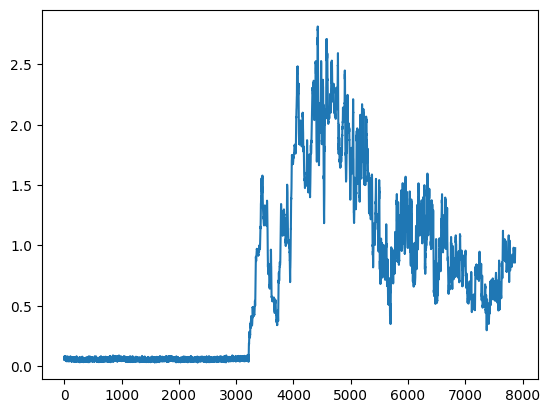

In [1392]:
plt.plot(sampleNumberArray, amplitudeArray)

Using the scipy library, 128 were analyzed in 0.00011110305786132812 seconds.


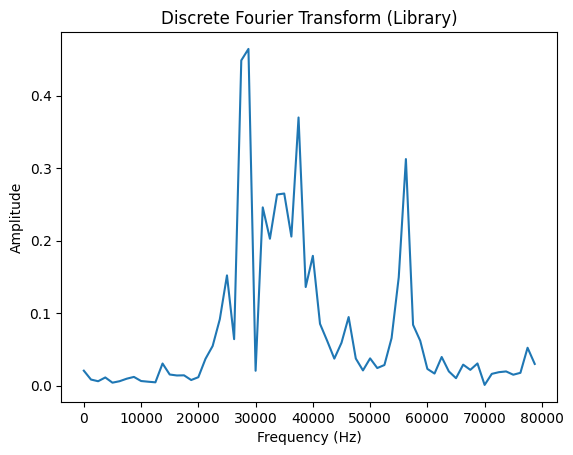

In [1393]:
# DISCRETE FOURIER ANALYSIS USING SCIPY LIBRARY
# ----------------------------------------------

# For measuring execution time. 
start = time.time()

# Number of samples in normalized_tone
yf = fft(slidingTestSample)
xf = fftfreq(N, 1 / sampling_frequency)[:(N // 2)]

end = time.time()
print("Using the scipy library, " + str(N) + " were analyzed in " + str(end - start) + " seconds.")

plt.plot(xf, 2 / N * np.abs(yf[0 : N//2]))        # Ignore this error 

plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Discrete Fourier Transform (Library)")
plt.show()

In [1394]:
pd.DataFrame(xf)
pd.DataFrame()

""
